# Eigenfaces

### import packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
from time import perf_counter
from tqdm import tqdm, trange

%matplotlib inline

In [42]:
%cd ..
from rputil import *
%cd -

/mnt/c/Users/rishi/GitHub/icerm/random-projections
/mnt/c/Users/rishi/GitHub/icerm/random-projections/notebooks


### load data

In [3]:
m = 187500
n = 620

data = np.empty((m, n)) # images are 250x250x3

for i,filename in enumerate(glob.iglob('../datasets/lfw/**/*.jpg', recursive = True)):
    if i >= n:
        break
    im=Image.open(filename)
    data[:,i] = np.asarray(im).flatten()
    im.close()

In [4]:
data /= 255

#### column-center the data

In [6]:
data_mean = np.expand_dims(np.mean(data, axis=1),1)
data -= data_mean

### define factorization functions

In [7]:
start = perf_counter()
det_U, det_Sigma, det_Vh = np.linalg.svd(data, full_matrices=False)
end = perf_counter()
det_time = end - start

### calculate eigenfaces

In [9]:
k = 350

In [10]:
det_basis = det_U[:,:k]
print(det_basis.shape)

(187500, 350)


In [11]:
rand_basis = random_svd_rank_k(data, k, power=0, only_basis=True)
print(rand_basis.shape)

(187500, 350)


In [12]:
def normalize_basis(basis):
    return (basis - np.min(basis))/(np.max(basis)-np.min(basis))

In [13]:
normalized_det_basis = normalize_basis(det_basis)

In [14]:
normalized_rand_basis = normalize_basis(rand_basis)

In [38]:
def plot_examples(rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15 / cols * rows))
    for i,ax in enumerate(axes.flat):
        ax.imshow((data[:,i]+np.squeeze(data_mean)).reshape(250,250,3))

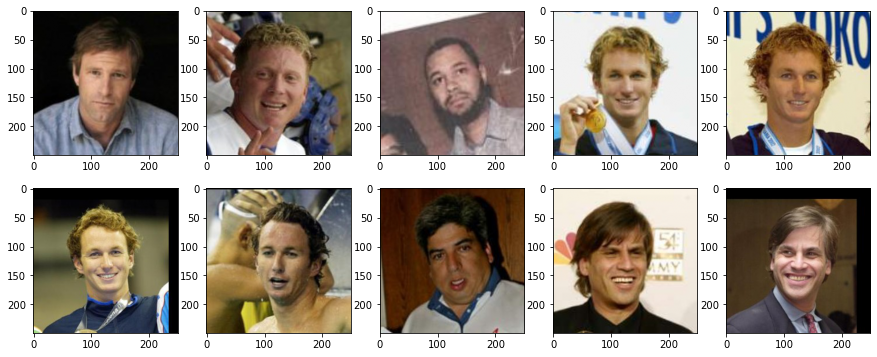

In [39]:
plot_examples(2, 5)

In [15]:
def plot_eigenfaces(basis, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(15, 15 / cols * rows))
    for i in range(rows):
        for j in range(cols):
            ax[i][j].imshow(basis[:,i * cols + j].reshape(250,250,3))

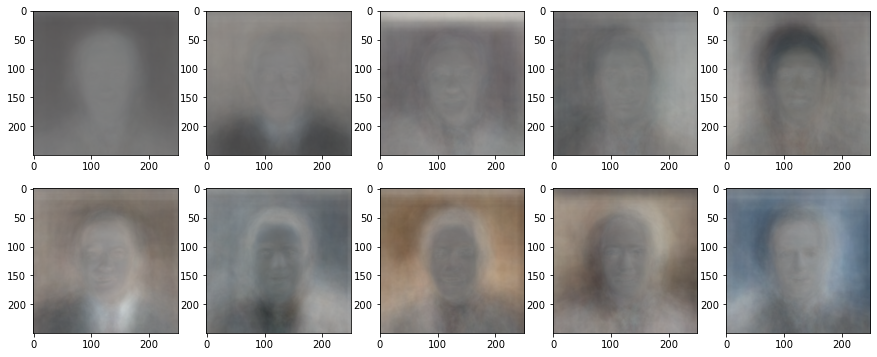

In [16]:
plot_eigenfaces(normalized_det_basis, 2, 5)

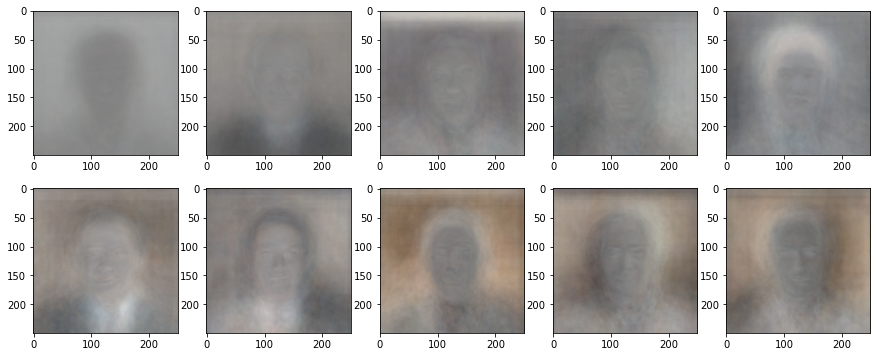

In [17]:
plot_eigenfaces(normalized_rand_basis, 2, 5)

### reconstruct an image 

In [44]:
specific_image = np.asarray(Image.open('../examples/eigenfaces/sean250.png')).flatten() / 255

In [45]:
det_coefficients = (specific_image - np.squeeze(data_mean)) @ det_basis

In [46]:
rand_coefficients = (specific_image - np.squeeze(data_mean)) @ rand_basis

In [47]:
det_reconstructed_image = np.squeeze(data_mean) + (det_basis @ det_coefficients)

In [48]:
rand_reconstructed_image = np.squeeze(data_mean) + (rand_basis @ rand_coefficients)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


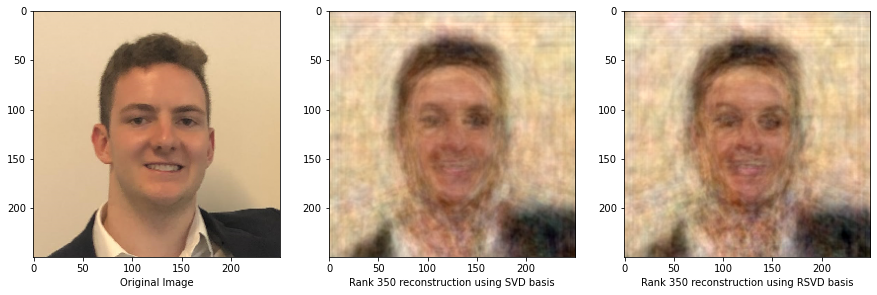

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(specific_image.reshape(250,250,3))
ax[0].set_xlabel('Original Image')
ax[1].imshow(det_reconstructed_image.reshape(250,250,3))
ax[1].set_xlabel('Rank 350 reconstruction using SVD basis')
ax[2].imshow(rand_reconstructed_image.reshape(250,250,3))
ax[2].set_xlabel('Rank 350 reconstruction using RSVD basis');

### evaluate performance

In [25]:
domain = np.arange(50, 550, step=50)

rand_times = []
errors = []

for k in tqdm(domain):
    det_approx = svd_rank_k(data, k)
    
    start = perf_counter()
    rand_approx = random_svd_rank_k(data, k, power=0)
    end = perf_counter()
    rand_time = end - start
    
    rand_times.append(rand_time / det_time)
    
    
    error = (np.linalg.norm(data - rand_approx) 
             - np.linalg.norm(data - det_approx)) / np.linalg.norm(data - det_approx)
    errors.append(error)

Computing RSVD with rank k=50...
Computing RSVD with rank k=100...
Computing RSVD with rank k=150...
Computing RSVD with rank k=200...
Computing RSVD with rank k=250...
Computing RSVD with rank k=300...
Computing RSVD with rank k=350...
Computing RSVD with rank k=400...
Computing RSVD with rank k=450...
Computing RSVD with rank k=500...


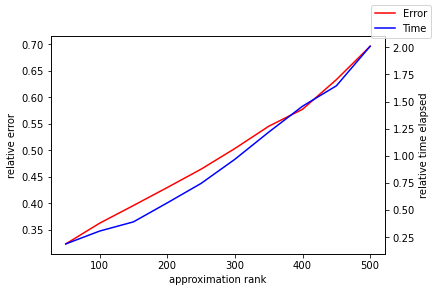

In [40]:
fig, ax = plt.subplots()

ax.set_xlabel('approximation rank')

ax.plot(domain, errors, c='r', label='Error')
ax.set_ylabel('relative error')

ax2 = ax.twinx()

ax2.plot(domain, rand_times, c='b', label='Time')
ax2.set_ylabel('relative time elapsed')

fig.legend(loc='upper right');

### statistics on rsvd

In [28]:
n_sample = 10
rsvd_error = np.empty((domain.shape[0], n_sample))
svd_error = np.empty(domain.shape[0])

rsvd_stat = np.empty((7,domain.shape[0]))

for i in trange(domain.shape[0]):
    svd_error[i] = np.linalg.norm((det_U[:,:domain[i]] 
                                   @ np.diag(det_Sigma[:domain[i]]) 
                                   @ det_Vh[:domain[i]]) 
                                  - data) / np.linalg.norm(data)
    for j in range(n_sample):
        rsvd_error[i][j] = np.linalg.norm(random_svd_rank_k(data, domain[i], power=0) 
                                          - data) / np.linalg.norm(data)

Sampling with rank k=50
Sampling with rank k=100
Sampling with rank k=150
Sampling with rank k=200
Sampling with rank k=250
Sampling with rank k=300
Sampling with rank k=350
Sampling with rank k=400
Sampling with rank k=450
Sampling with rank k=500


In [29]:
for i in range(domain.shape[0]):
    rsvd_stat[0][i] = np.min(rsvd_error[i])
    rsvd_stat[1][i] = np.quantile(rsvd_error[i], 0.25)
    rsvd_stat[2][i] = np.median(rsvd_error[i])
    rsvd_stat[3][i] = np.quantile(rsvd_error[i], 0.75)
    rsvd_stat[4][i] = np.max(rsvd_error[i])
    rsvd_stat[5][i] = np.mean(rsvd_error[i])
    rsvd_stat[6][i] = np.std(rsvd_error[i])

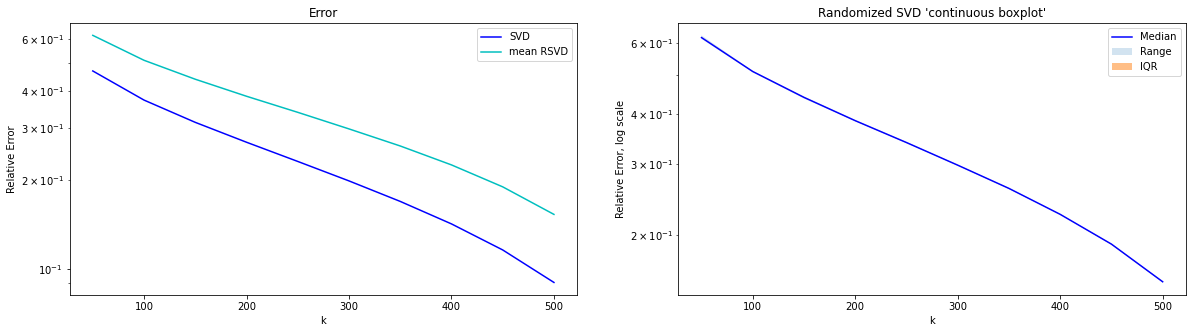

In [30]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(domain, svd_error, c='b', label='SVD')
ax[0].plot(domain, rsvd_stat[5], c='c', label='mean RSVD')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Error')

ax[1].plot(domain, rsvd_stat[2], c='b', label='Median')
ax[1].fill_between(domain, rsvd_stat[4], rsvd_stat[0], alpha=0.2, label='Range', lw=1)
ax[1].fill_between(domain, rsvd_stat[1], rsvd_stat[3], alpha=0.5, label='IQR', lw=1)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Relative Error, log scale')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Randomized SVD \'continuous boxplot\'')


plt.show()

In [31]:
print(f"For k=200: Mean={rsvd_stat[5][3]}, StDev={rsvd_stat[6][3]}")

For k=200: Mean=0.3843942224869132, StDev=0.0009843370719946857
